### Importing header files

In [1]:
# Header Files
import PyPDF2
import spacy
import csv
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.ticker as ticker
import tabula
import numpy as np
from collections import Counter
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from wordcloud import WordCloud
from IPython.display import HTML
from tika import parser
from easymoney.money import EasyPeasy
import geopandas



### Loading the cleaned data

In [2]:
df=pd.read_csv("../Data/ministry_budget_provision/ministry_expenditure_cleaned.csv")

df['Total'].describe()

count    9.760000e+02
mean     4.464871e+04
std      2.077753e+05
min     -1.675900e+02
25%      6.129300e+02
50%      2.348580e+03
75%      1.019376e+04
max      2.784200e+06
Name: Total, dtype: float64

### Top 10 and Bottom 10 funded Ministries

In [3]:
def max_min(year):
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(15, 10))
    fig.suptitle('Budget Year: ' + str(year) + '-' + str(year+1)[2:] )
    
    # MAXIMUM
    dff = (df[df['Year']==(str(year) + '-' + str(year+1)[2:])].sort_values(by='Total', ascending=False).head(11))
    dff.reset_index(inplace=True)
    dff.drop(0,inplace=True)
    sns.barplot(dff['Total'],dff['Ministry'], alpha=0.8, ax=ax1)
    ax1.set_title('Top 10 Budget Allocated Ministries')
    ax1.set_ylabel('Total(In crores of Rupees)')
    
    # MINIMUM
    dff = (df[df['Year']==(str(year) + '-' + str(year+1)[2:])].sort_values(by='Total', ascending=True).head(10))
    dff.reset_index(inplace=True)
    sns.barplot(dff['Total'],dff['Ministry'], alpha=0.8, ax=ax2)
    ax2.set_title('Bottom 10 Budget Allocated Ministries')
    ax2.set_ylabel('Total(In crores of Rupees)') 
    
    plt.savefig('../Data/graphs/BY_' + str(year) + '-' + str(year+1)[2:] +'_TB.png', bbox_inches='tight')

    plt.show()


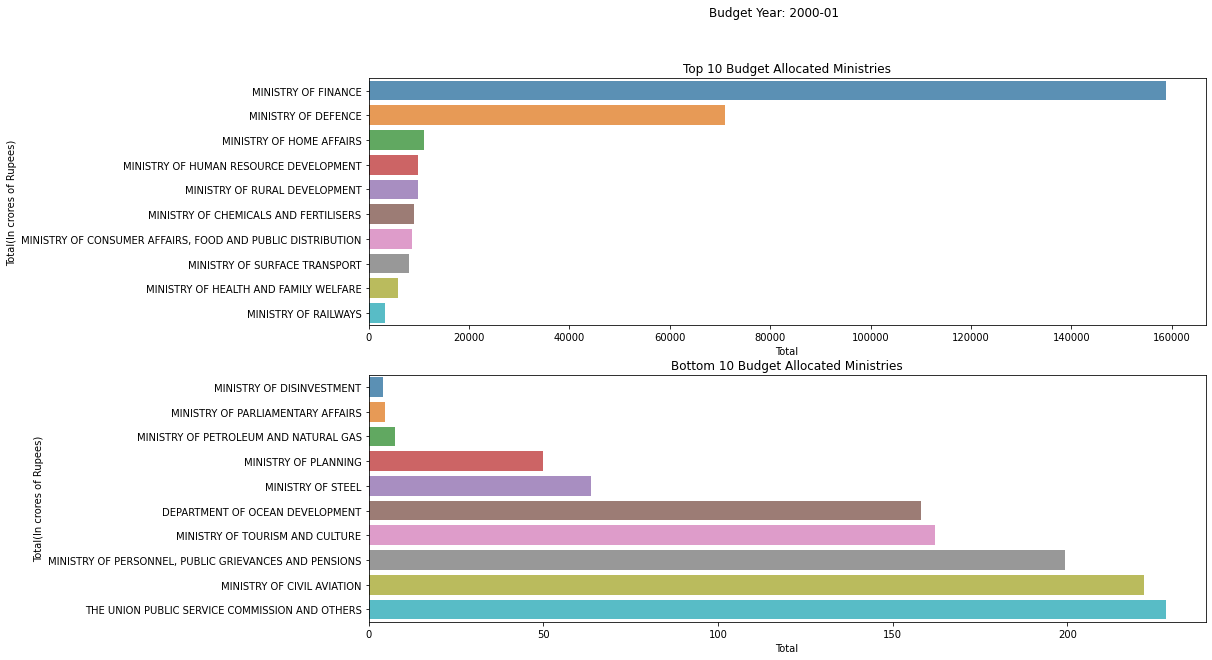

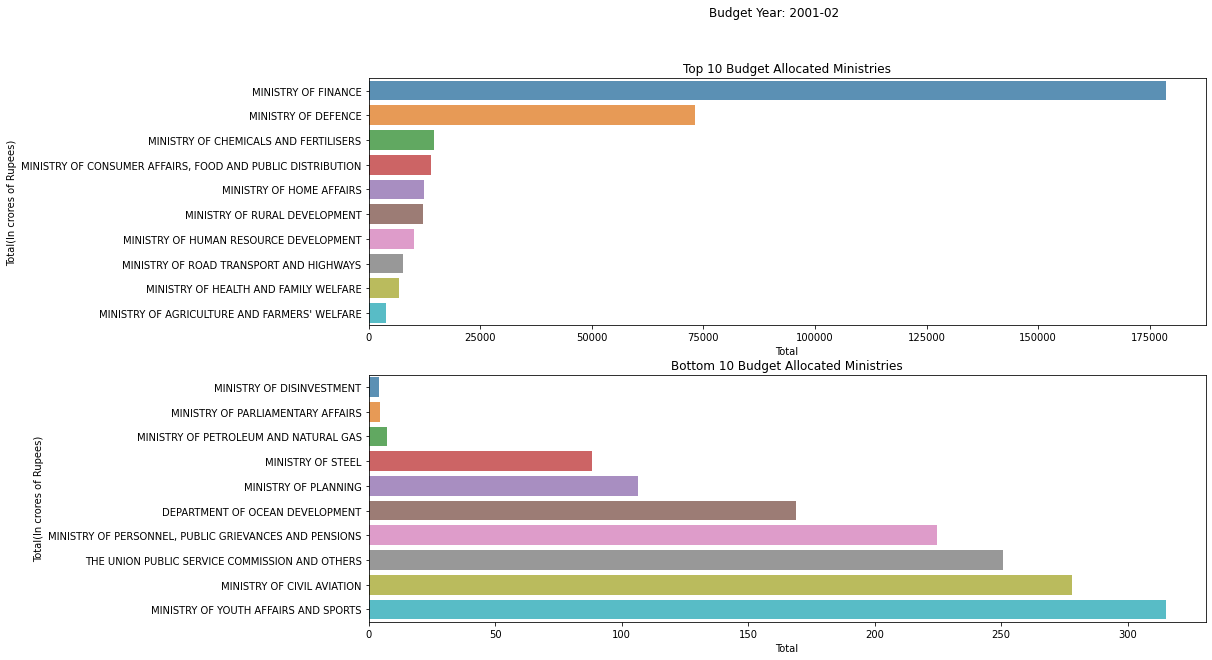

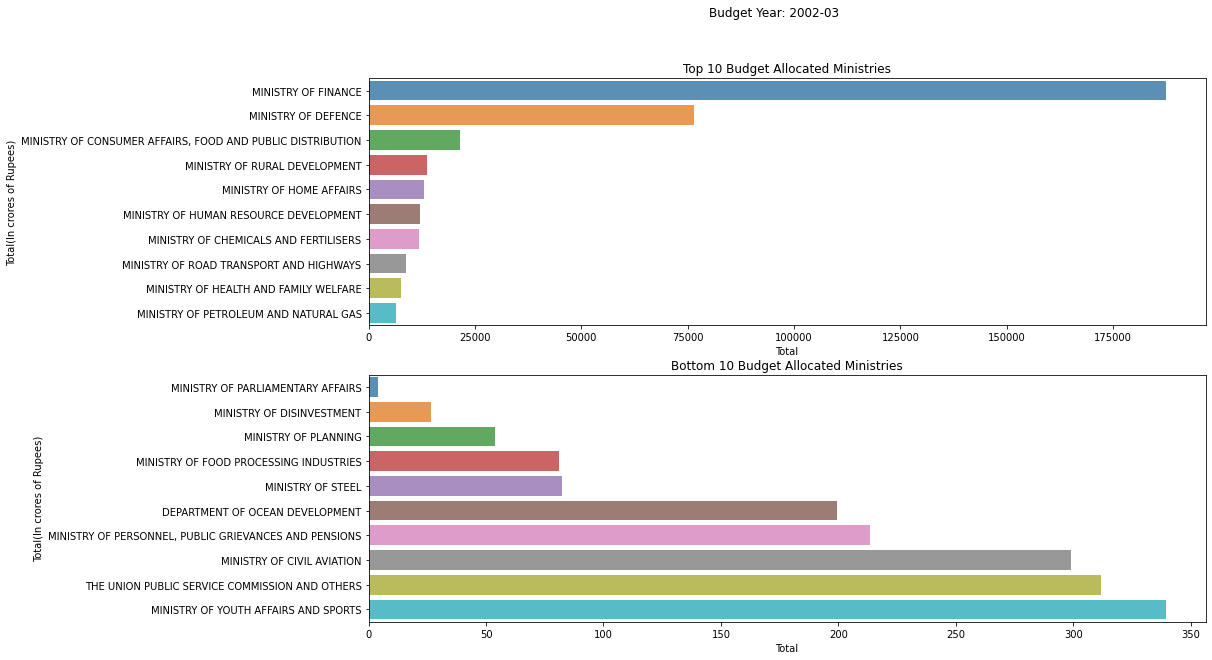

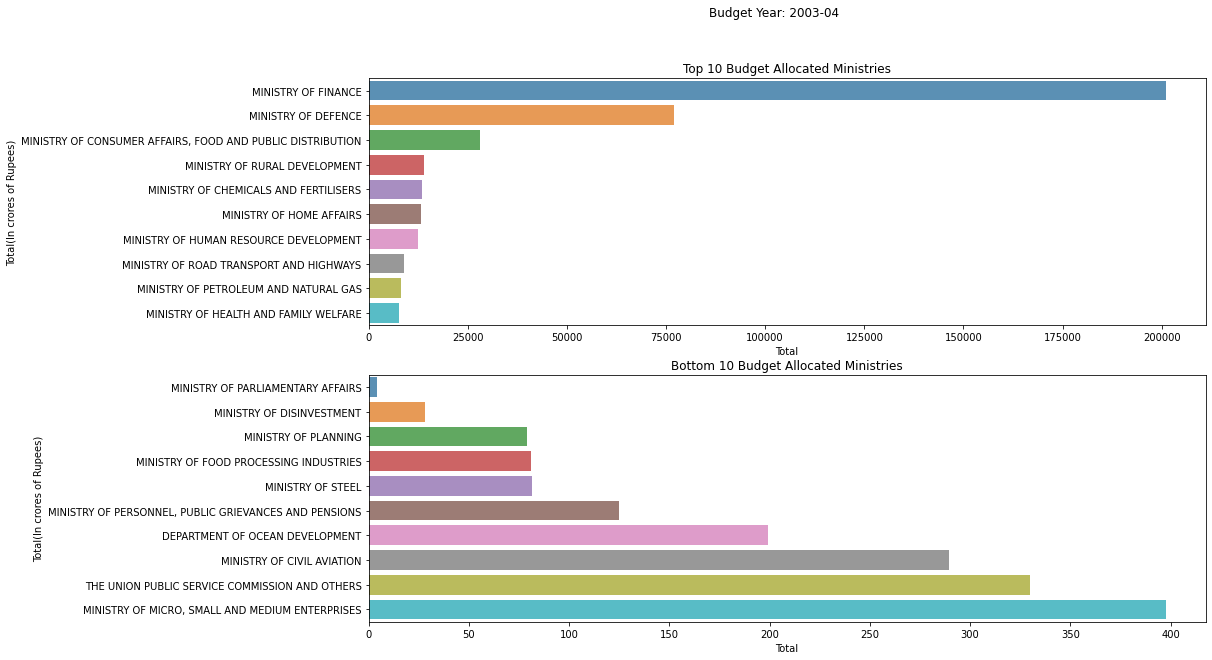

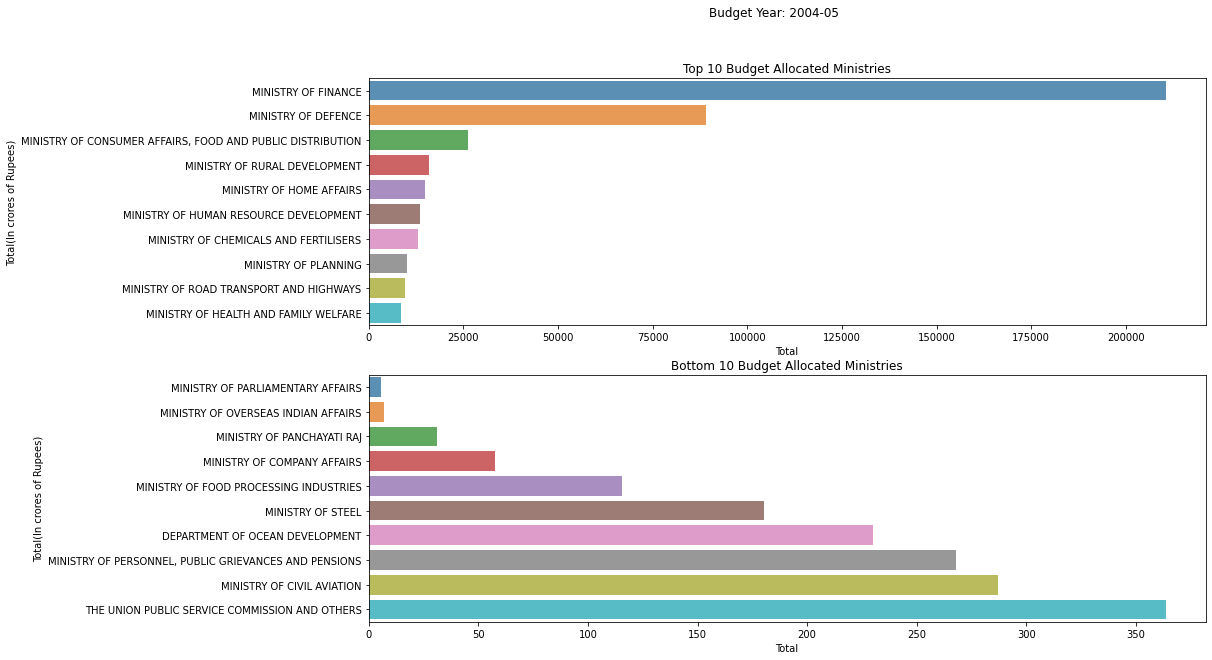

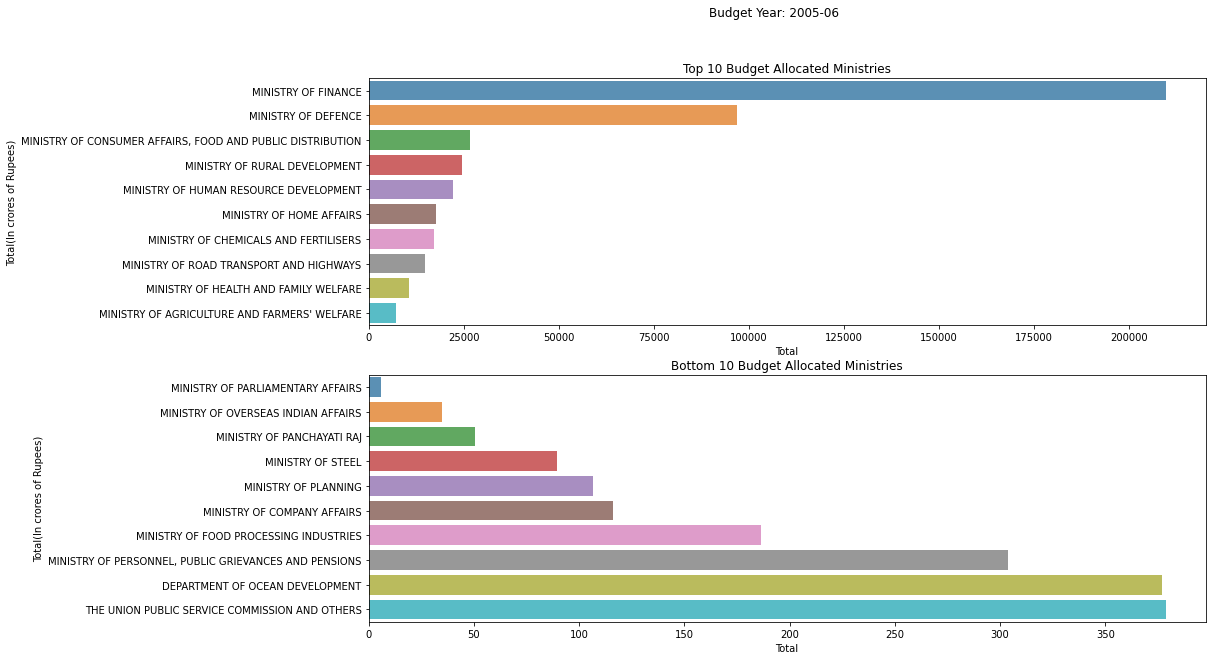

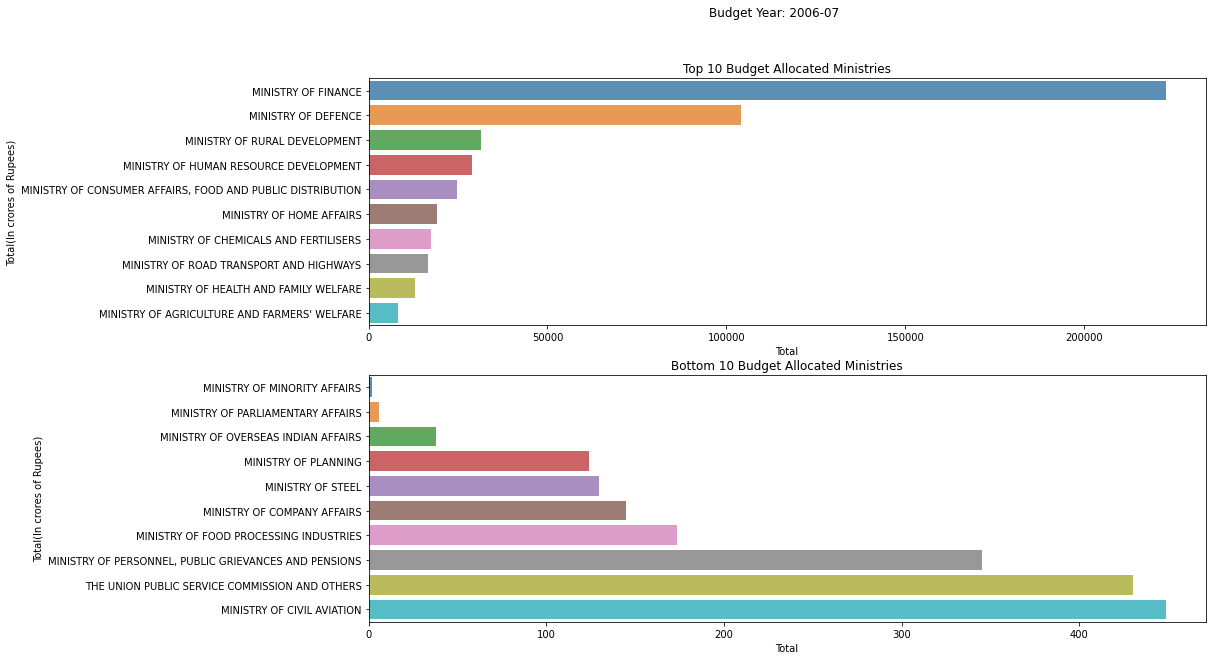

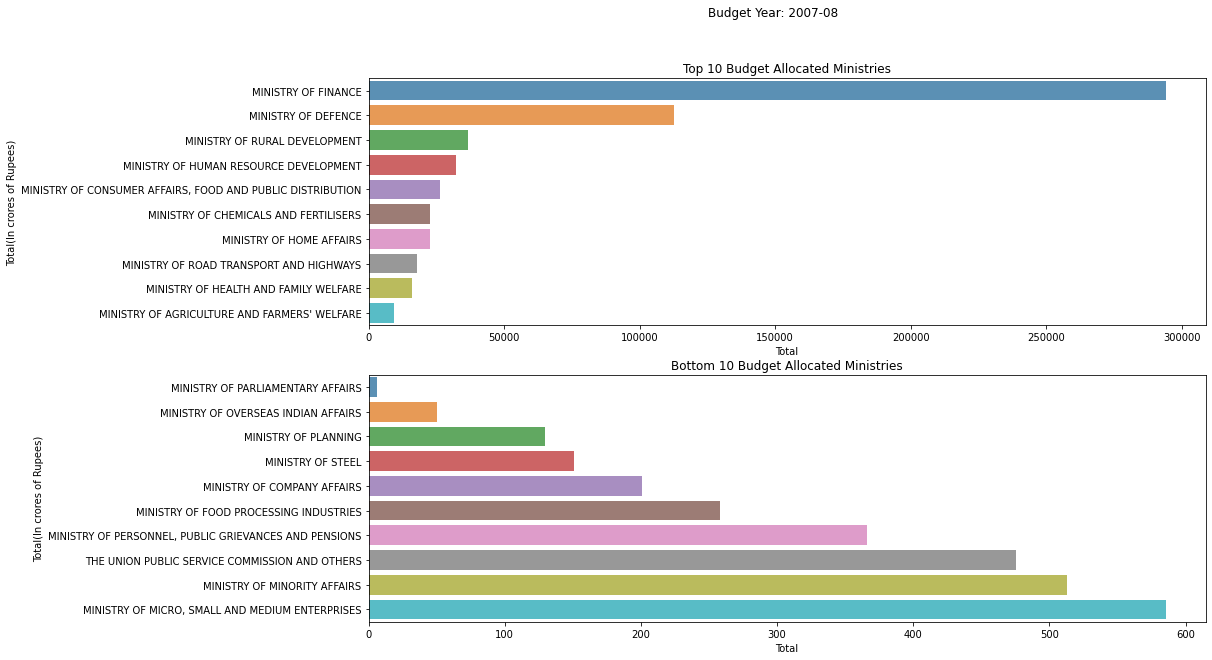

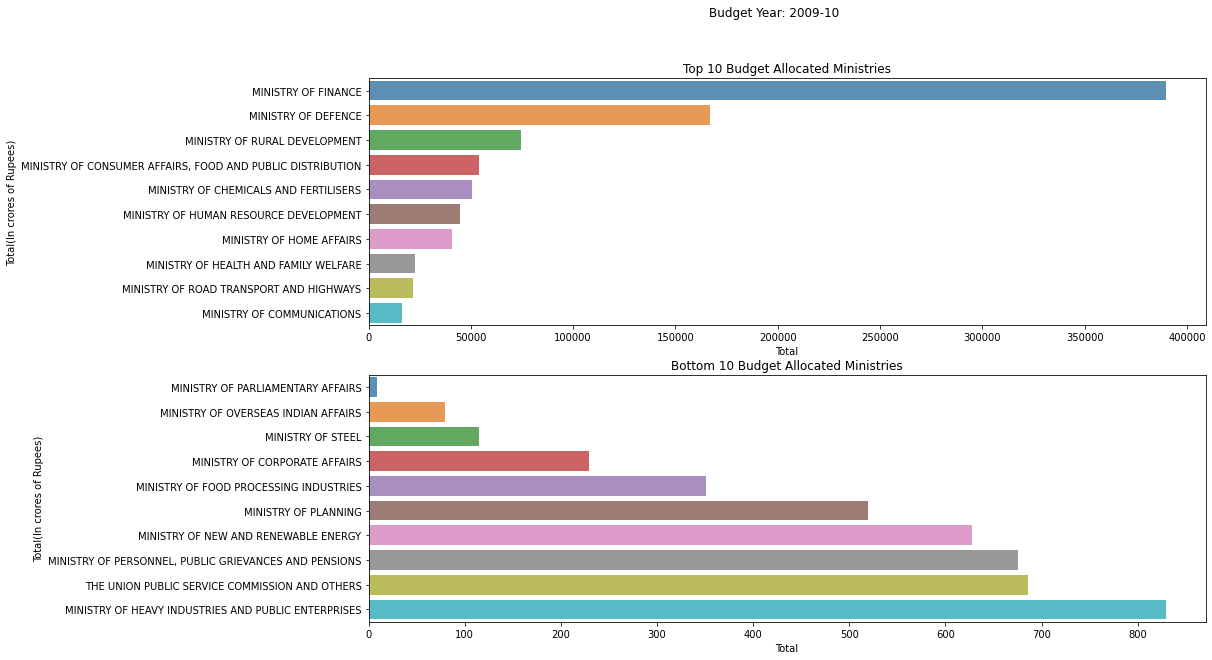

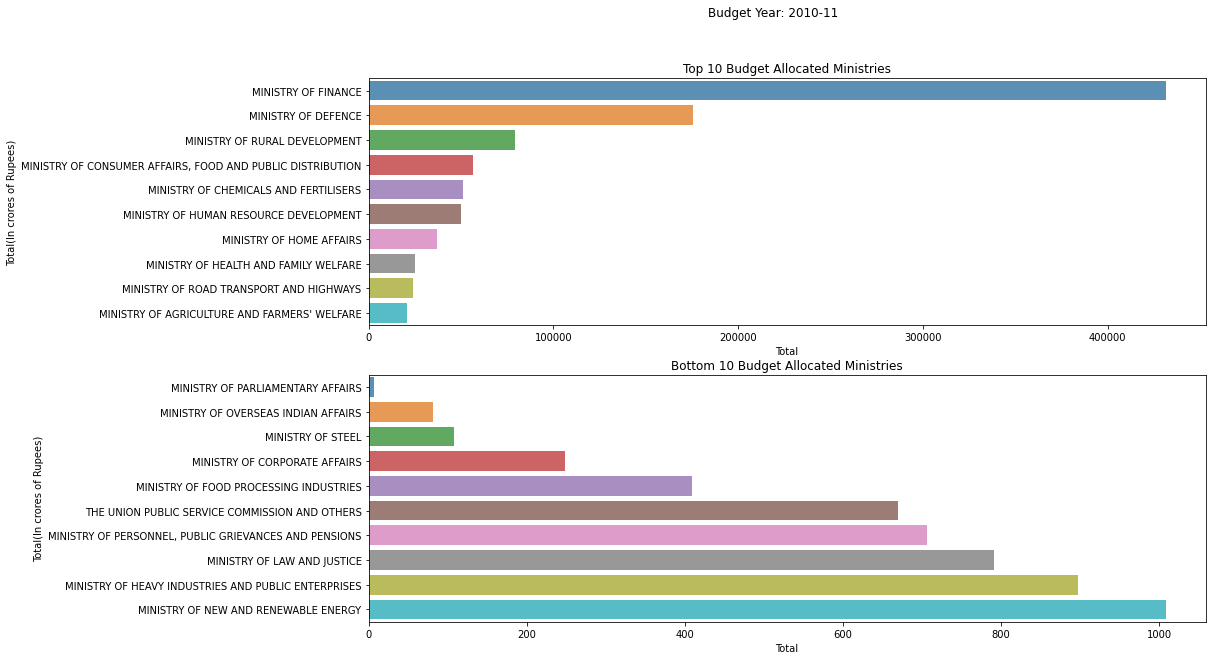

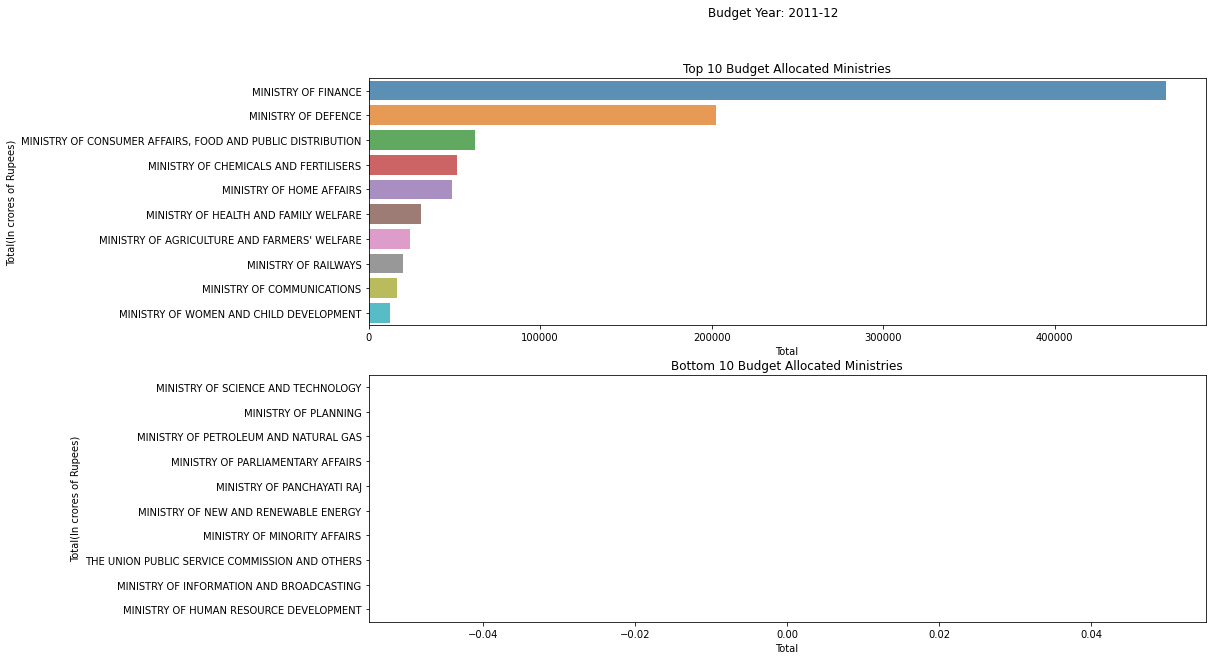

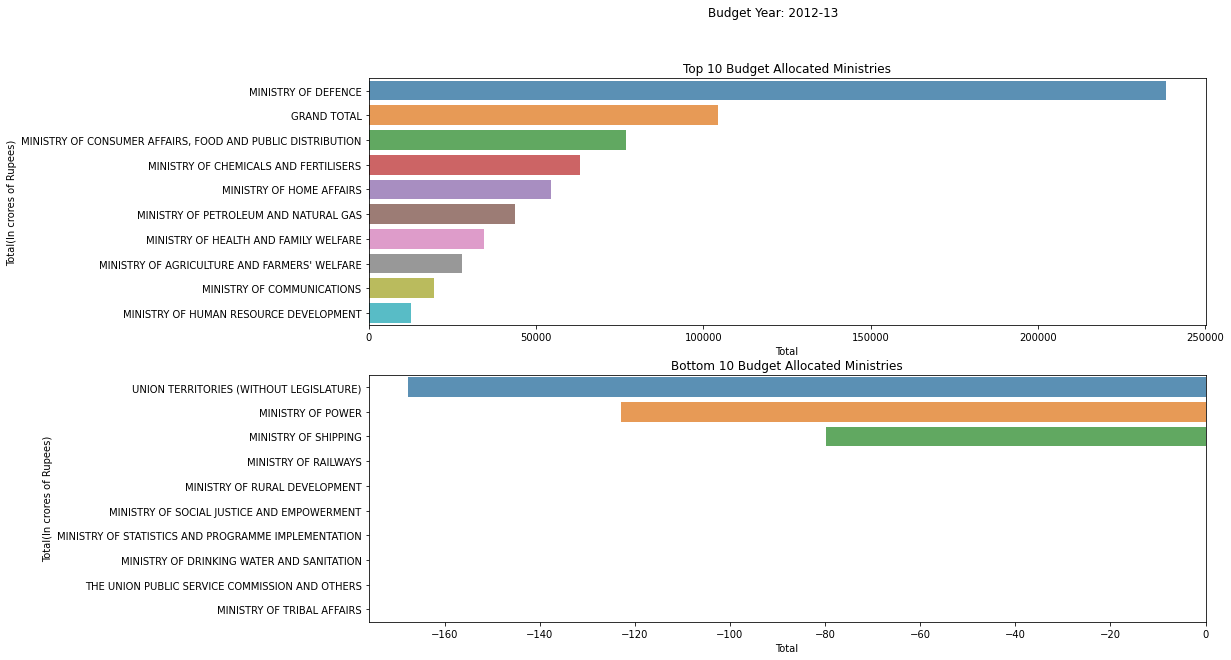

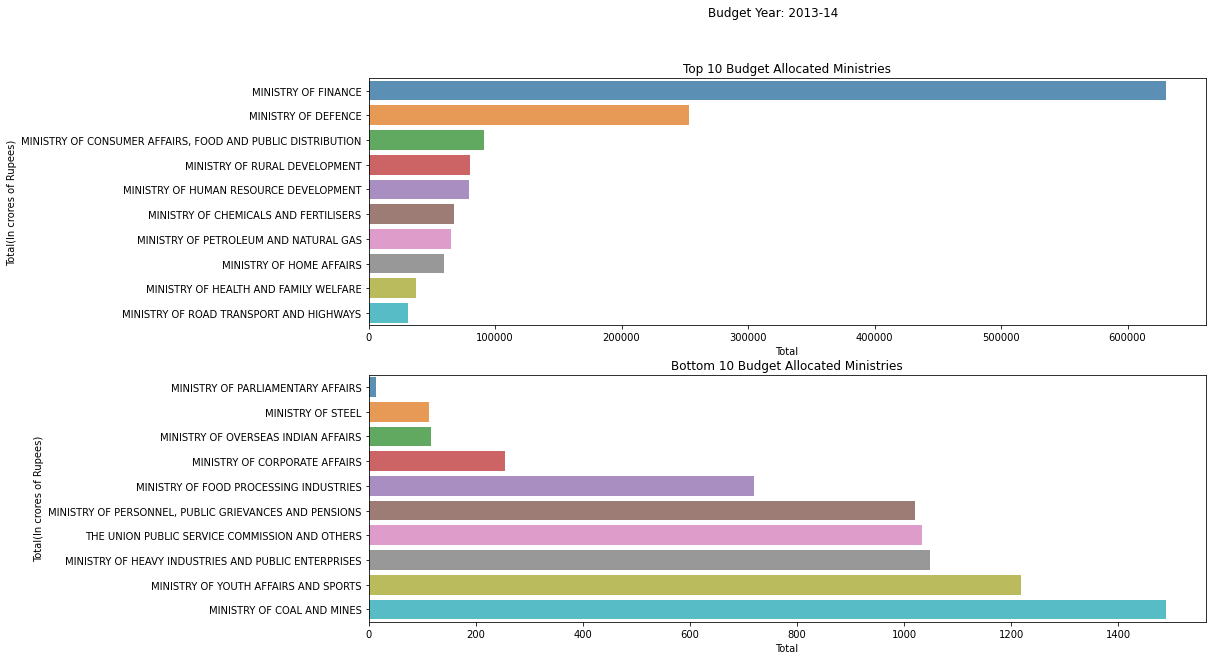

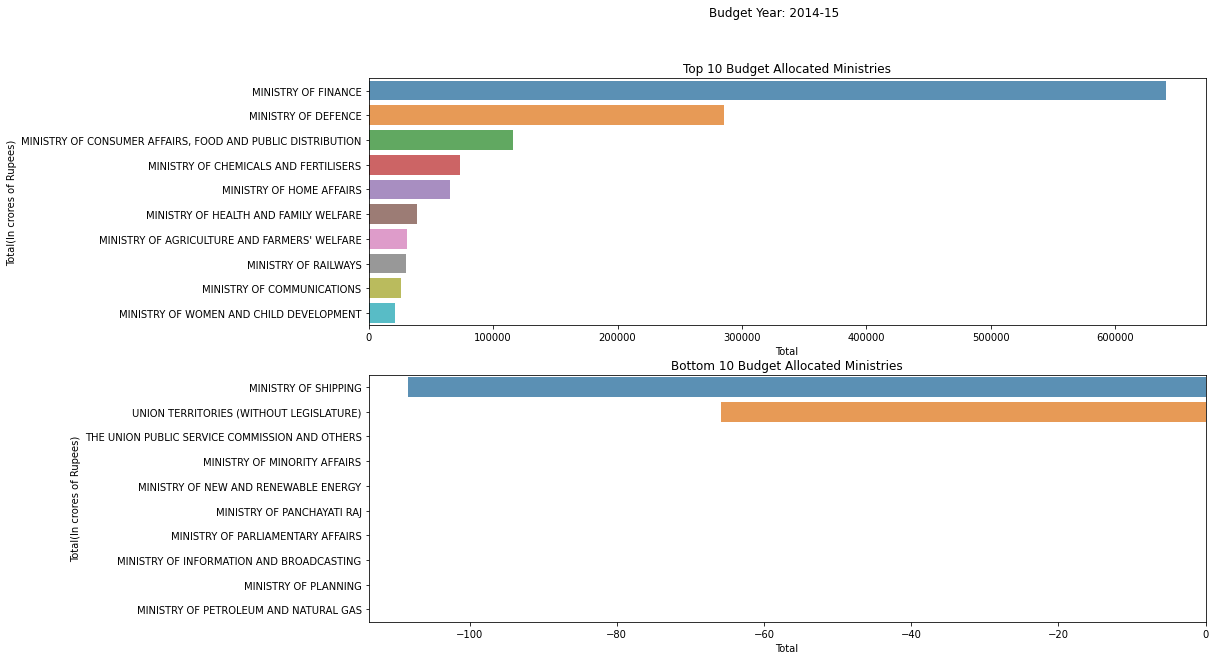

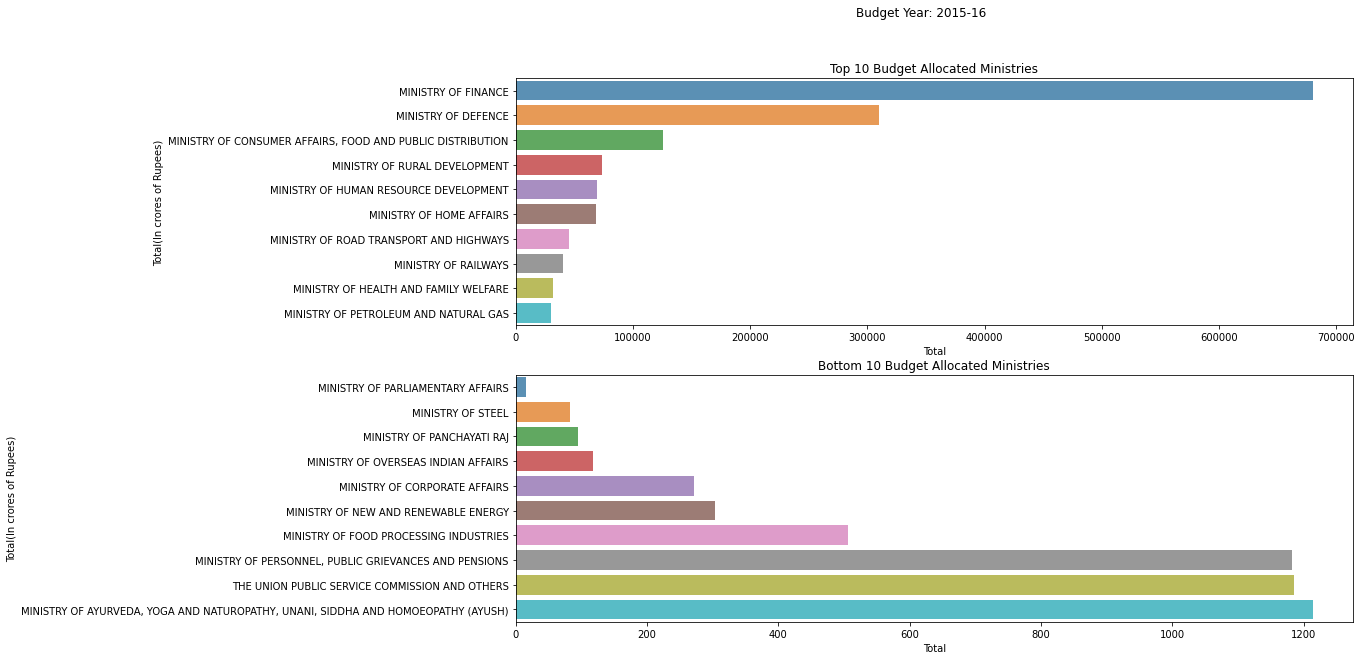

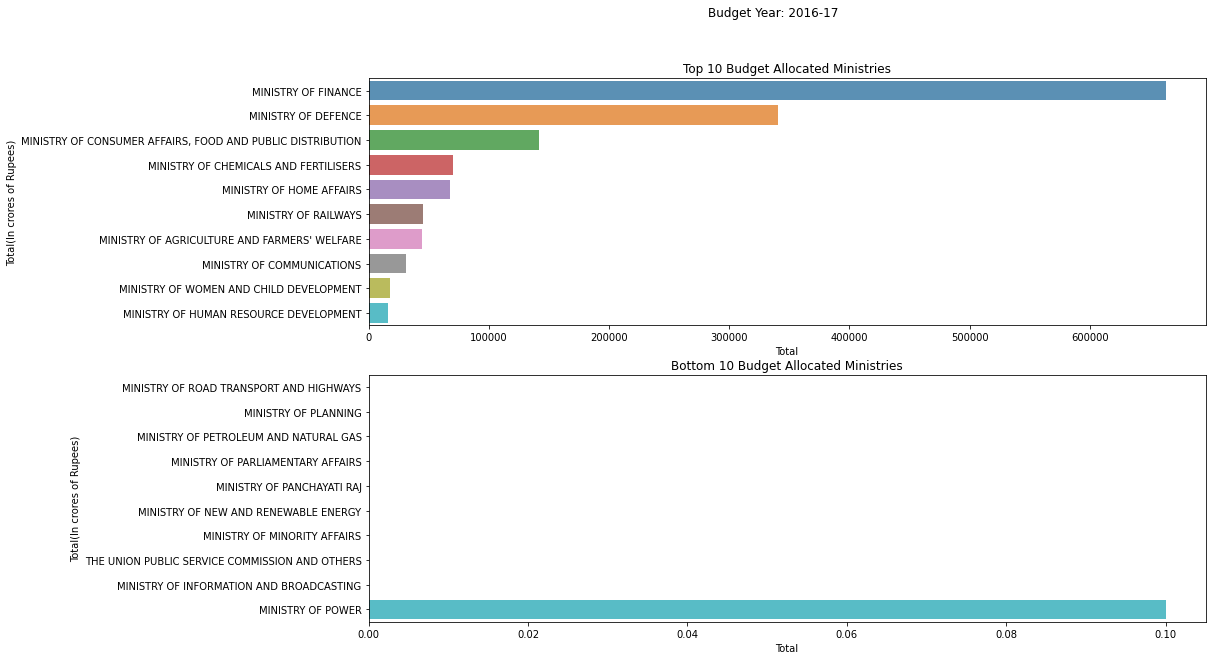

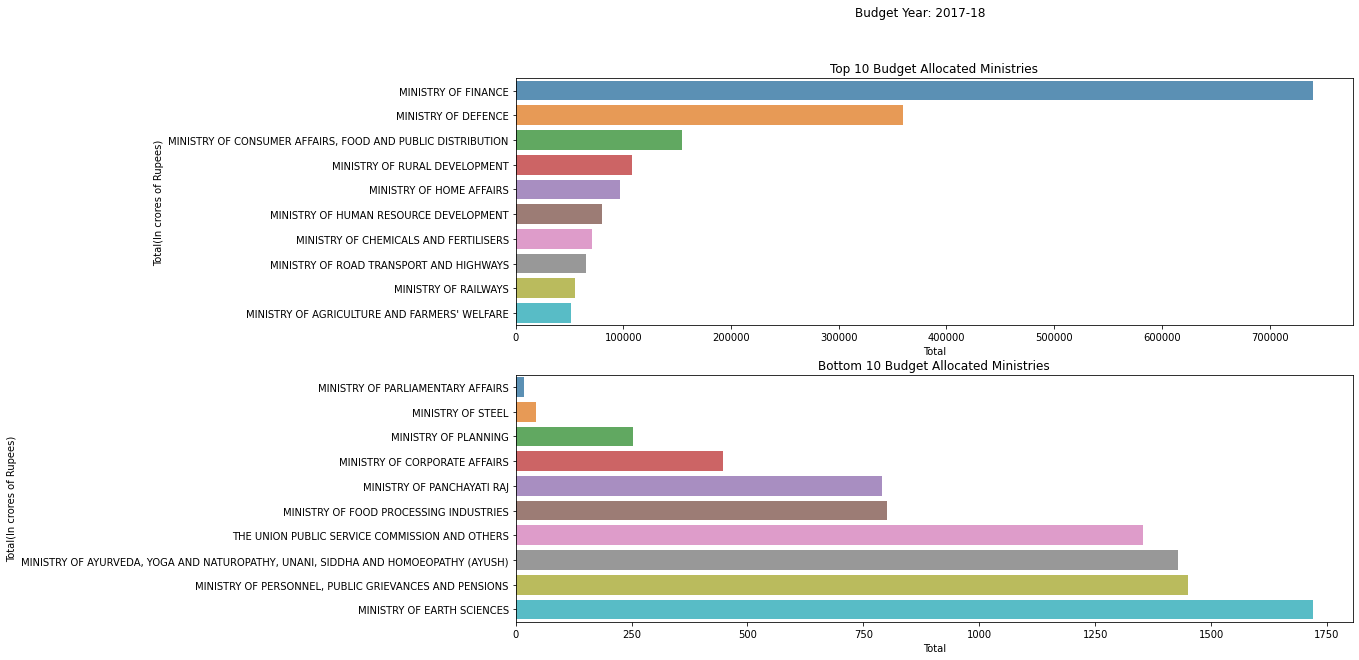

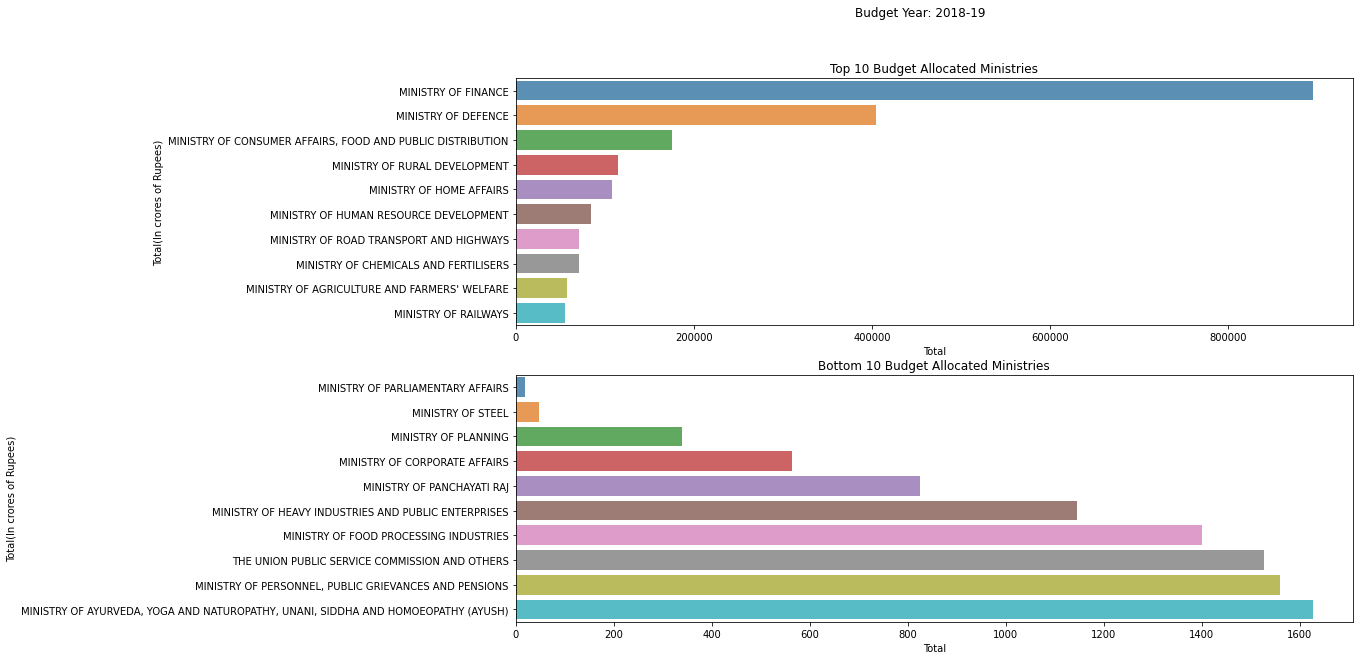

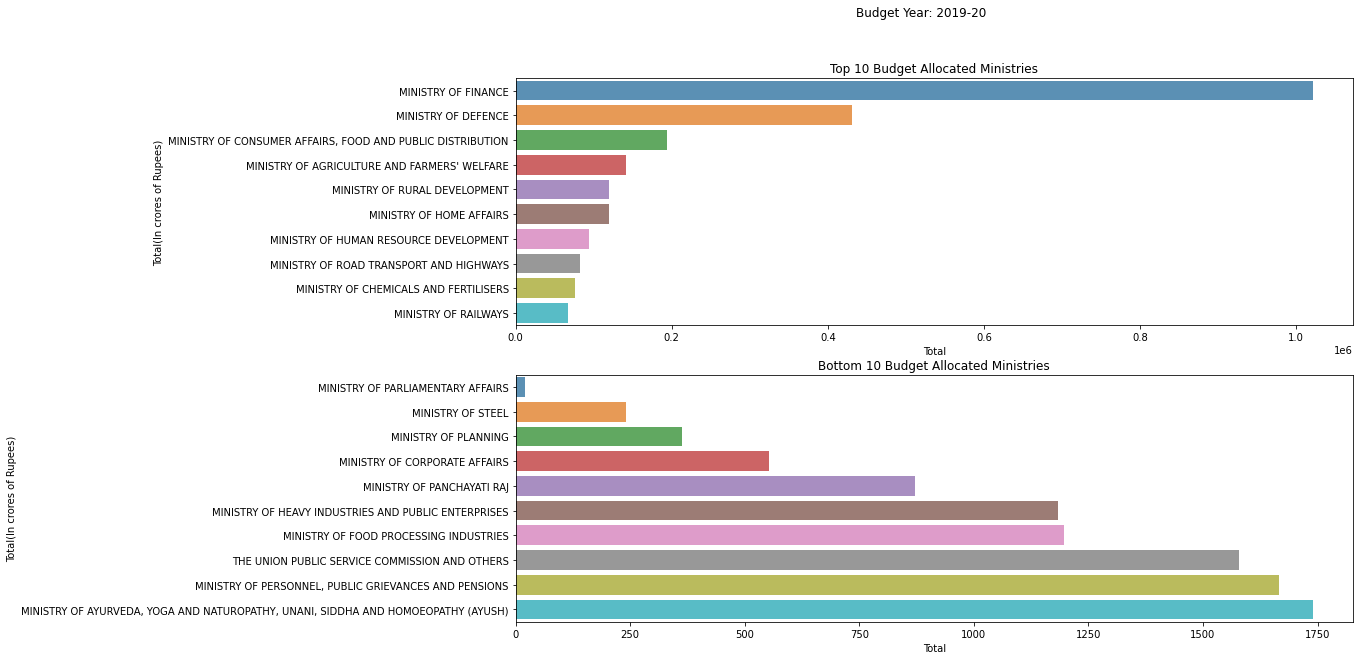

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [4]:
[max_min(i) for i in range(2000,2020) if i != 2008]


In itself, the top and bottom ministries don't add much value, so let's plot a bar race graph to find the cumulatively top and bottom ministries for the last 20 years.

### Cumulative Budget Analysis

#### Creating the new cumulative column

In [5]:
df['Cumulative_Total']=0

for ministry in df['Ministry'].unique():
    req_index=df[df['Ministry']==ministry].index
    df.loc[req_index, 'Cumulative_Total']= df.loc[req_index, 'Total'].cumsum()

#### Creating the barchart race for cumulative funding of ministries

In [6]:
def draw_barchart_top(year):
    
    dff = (df[df['Year']==(str(year) + '-' + str(year+1)[2:])].sort_values(by='Cumulative_Total', ascending=False).head(11)) # The top one will be "Grand Total" 
    ax.clear()
    dff.reset_index(inplace=True)
    dff.drop([0],inplace=True)  # Drop the "Grand total" valued row
    dx = dff['Total'].max() / 200
    sns.barplot(dff['Cumulative_Total'], dff['Ministry'],ax=ax)
    
    

    for i, (value, name) in enumerate(zip(dff['Cumulative_Total'],dff['Ministry'])):
        ax.text(value-dx, i,name, size=10, weight=600, ha='right', va='bottom')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
  
    
    
    ax.text(1, 0.4, str(year) + '-' + str(year+1)[2:], transform=ax.transAxes, size=30, ha='right')
    ax.text(0, 1.06, 'Total(In crores of Rupees)', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, 'The top budgeted ministries from 2000 to 2019',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    ax.text(1, 0, 'by Nikhil Nair', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)
    ax.yaxis.label.set_visible(False)


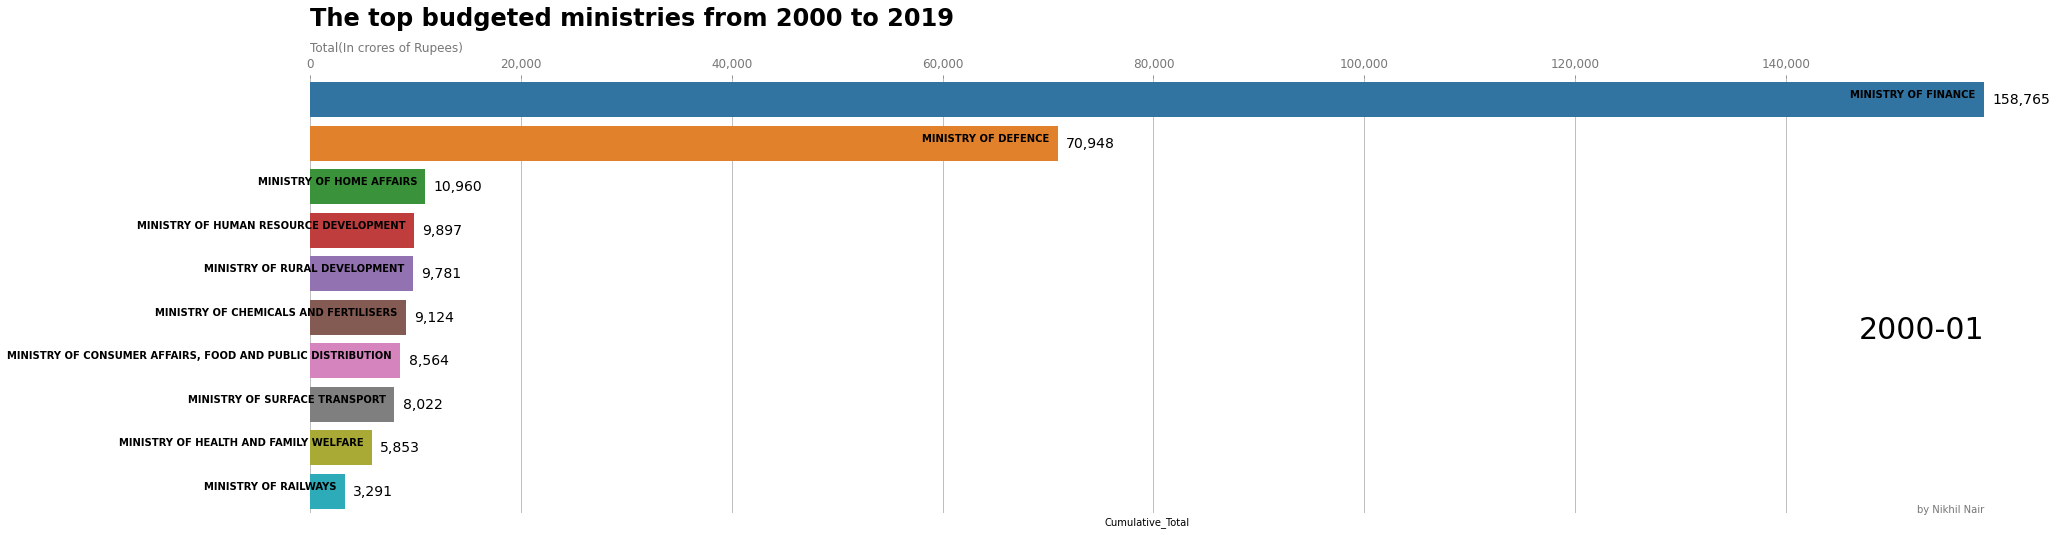

In [7]:
fig, ax = plt.subplots(figsize=(30, 8))
frames=[i for i in range(2000,2020) if i != 2008]
animator = animation.FuncAnimation(fig, draw_barchart_top, frames=frames, interval=1000)
HTML(animator.to_jshtml()) 

## Currently the save mechanism using animator has a known bug. You can use the following after it gets fixed
# animator.save('../Data/graphs/ministry_bar_race_top.gif', dpi=80, writer='imagemagick')


#### Cleaning data before plotting the bottom funded

In [8]:
# Only plotting the ministries that are present across all years

df_mi= df['Ministry'].value_counts()
common_col=list(df_mi[df_mi >= 19].keys())
total_col=list(df_mi.keys())

delete_col=list(set(common_col) ^ set(total_col))


delete_col.append("UNION TERRITORIES")
delete_col.append("MINISTRY OF AYURVEDA, YOGA AND NATUROPATHY, UNANI, SIDDHA AND HOMOEOPATHY")
df_mi=df
for col in delete_col:
     df_mi=df_mi[~df_mi.Ministry.str.contains(str(col))]


C:\Users\nnair\miniconda3\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [9]:
def draw_barchart_bottom(year):
    
    dff = (df_mi[df_mi['Year']==(str(year) + '-' + str(year+1)[2:])].sort_values(by='Cumulative_Total', ascending=True).head(10))
    ax.clear()
    dff.reset_index(inplace=True)
    dx = dff['Total'].max() / 200
    sns.barplot(dff['Cumulative_Total'], dff['Ministry'],ax=ax)
    
    

    for i, (value, name) in enumerate(zip(dff['Cumulative_Total'],dff['Ministry'])):
        ax.text(value-dx, i,name, size=10, weight=600, ha='right', va='bottom')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
  
    
    
    ax.text(1, 0.4, str(year) + '-' + str(year+1)[2:], transform=ax.transAxes, size=30, ha='right')
    ax.text(0, 1.06, 'Total(In crores of Rupees)', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, 'The top budgeted ministries from 2000 to 2019',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    ax.text(1, 0, 'by Nikhil Nair', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)
    ax.yaxis.label.set_visible(False)


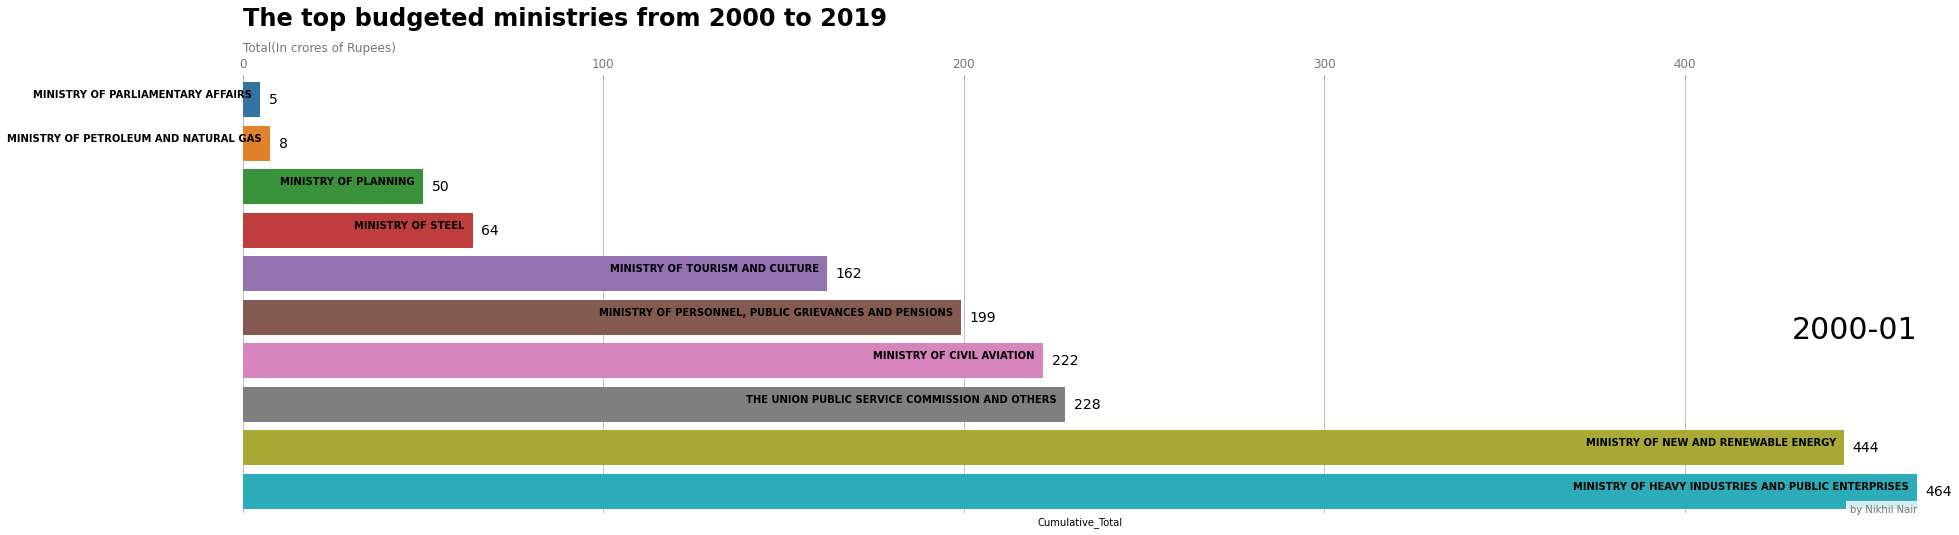

In [10]:
fig, ax = plt.subplots(figsize=(30, 8))
frames=[i for i in range(2000,2020) if i != 2008]
animator = animation.FuncAnimation(fig, draw_barchart_bottom, frames=frames, interval=1000)
HTML(animator.to_jshtml()) 

## Currently the save mechanism using animator has a known bug. You can use the following after it gets fixed
# animator.save('../Data/graphs/ministry_bar_race_bottom.gif', dpi=80, writer='imagemagick')


### Minister wise budget allocation

#### Extracting the minister information from budget speeches

In [11]:
df['Finance Minister']="None"

for year in range(2000,2020):
    flag=0
    
    
    if year==2008:
        continue
        
    if year==2009 or year==2010:
        df['Finance Minister'][df['Year']==str(year) + '-' + str(year+1)[2:]]="PRANAB MUKHERJEE"
        continue
        
    raw = parser.from_file("../Data/budget_speeches/bs"+ str(year) + str(year+1)[2:] + ".pdf")
    full_text=raw['content'].upper()
    
    
    start="SPEECH   OF"
    
    if full_text.find(start)== -1:
        start="SPEECH  OF"
        
    if full_text.find(start)== -1:
        start="SPEECH OF"
        
    end="MINISTER"

    finance_minister=full_text[full_text.find(start)+len(start):full_text.find(end)]
    finance_minister=finance_minister.strip(" ")  
    finance_minister=finance_minister.strip("\n")
    finance_minister=finance_minister.upper()

    df['Finance Minister'] = np.where(df['Year']==str(year) + '-' + str(year+1)[2:], finance_minister, df['Finance Minister'])
        
    if year==2005 or year==2006:
        df['Finance Minister'][df['Year']==str(year) + '-' + str(year+1)[2:]]="P. CHIDAMBARAM"
            
    if year== 2015:
        df['Finance Minister'][df['Year']==str(year) + '-' + str(year+1)[2:]]="ARUN JAITLEY"
        
df['Finance Minister']=df['Finance Minister'].str.strip()        

C:\Users\nnair\miniconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\nnair\miniconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\nnair\miniconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Calculating inflation and finding out standardised total

In [12]:
df['Standardised_Total']=0
ep = EasyPeasy()
for row in range(len(df)):
    df['Standardised_Total'].iloc[row]= ep.normalize(amount=df["Total"].iloc[row], region="IND", from_year=int(df["Year"].iloc[row][:4]), base_currency="INR" ,to_year="2019")


C:\Users\nnair\miniconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


#### Grouping standardised totals by finance minister values

In [13]:
df_gt=df[df['Ministry']=="GRAND TOTAL"]
df_gt=df_gt.groupby('Finance Minister')['Standardised_Total'].sum()

uniq_df=df.drop_duplicates(['Finance Minister','Year'])

#### Plotting funds allocated by each minister

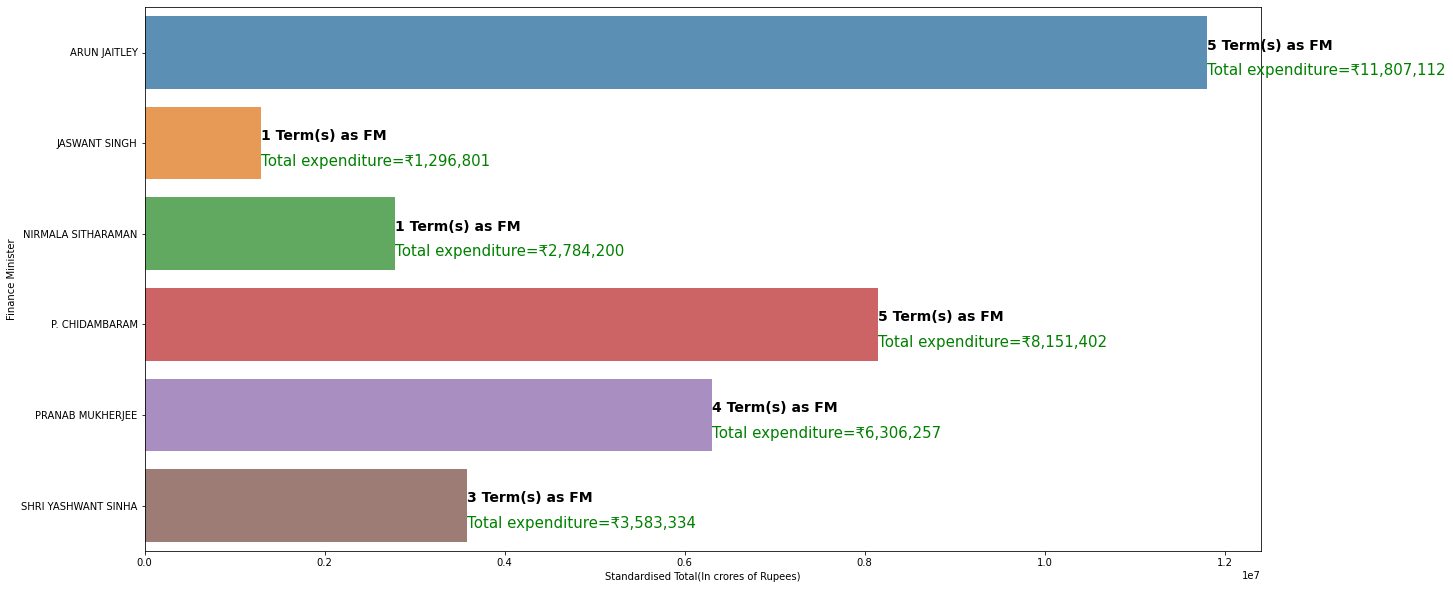

In [14]:
fig, ax = plt.subplots(1, 1,figsize=(20, 10))
sns.barplot(df_gt,df_gt.index, alpha=0.8, ax=ax)
plt.ylabel('Finance Minister')
plt.xlabel('Standardised Total(In crores of Rupees)')
dx=10
for i, (value, name) in enumerate(zip(df_gt,df_gt.index)):
        ax.text(value-dx, i+.25,"Total expenditure=₹"+ f'{value:,.0f}', size=15, color='#008000', ha='left', va='baseline')
        ax.text(value+dx, i, str(len(uniq_df[uniq_df['Finance Minister']==name])) + " Term(s) as FM", weight=600, size=14, ha='left',  va='bottom')
plt.savefig("../Data/graphs/fin_min_terms.png")
plt.show()        

#### Plotting individual contributions of each finance minister

In [15]:
def fin_min_budget(fm):
     
    dff = df[df['Finance Minister']==fm]
    dff = dff.sort_values(['Year']).reset_index(drop=True)
    ax= sns.barplot(dff['Year'],dff['Standardised_Total'], alpha=0.8, ci=None)
    

    #annotate axis = seaborn axis
    for p in ax.patches:
                 ax.annotate("Rs.%.0f Cr" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()-10000),
                     ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                     textcoords='offset points')
 
    
    
    plt.xlabel('Year')
    plt.ylabel('Total(In crores of Rupees)')
    plt.title('Finance Minister:'+ str(fm))
    plt.ylim((0,100000))

    plt.savefig("../Data/graphs/fin_terms_"+fm+".png", bbox_inches='tight')
    
    plt.show()


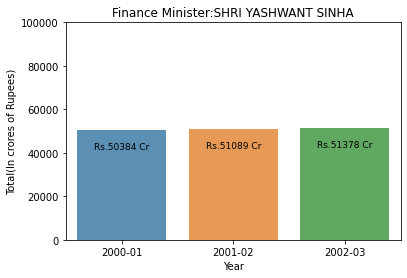

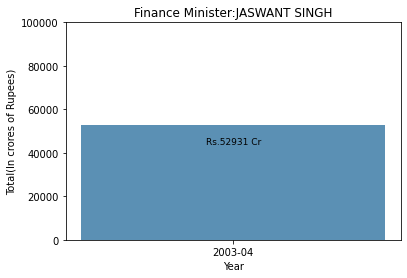

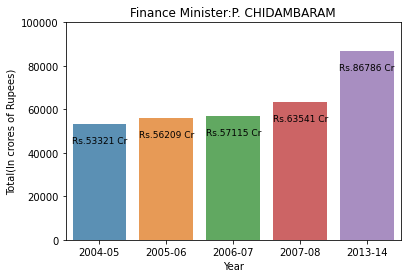

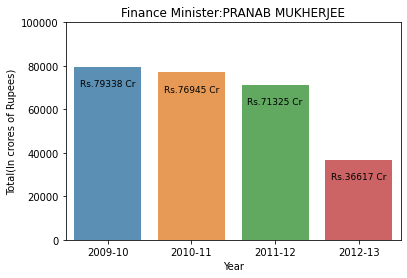

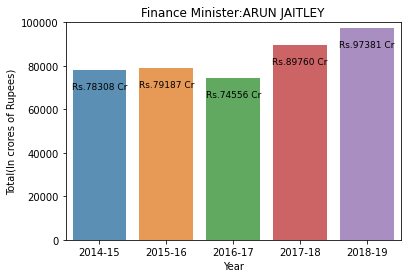

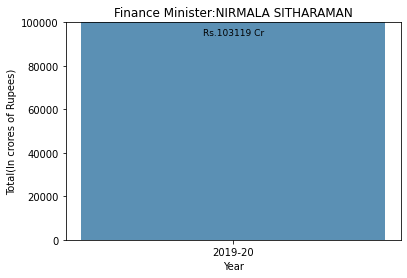

[None, None, None, None, None, None]

In [16]:
[fin_min_budget(x) for x in df['Finance Minister'].unique()]